# Visualize Image-Caption Pairs
This notebook loads and visualizes the first few image-caption pairs from the Flickr30k dataset to verify matching correctness.

In [1]:
import os
import csv
import torch
import random
from datasets import Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Set random seed for reproducibility
random.seed(42)

# Load and preprocess the Flickr30k dataset with random caption selection
def load_flickr30k_dataset(image_folder, caption_file, limit=None):
    # Track each image and its corresponding captions
    image_to_captions = {}
    
    with open(caption_file, newline='') as f:
        reader = csv.reader(f)
        next(reader)  # skip header
        
        for row in reader:
            image_name, _, caption = row
            image_path = os.path.join(image_folder, image_name)
            
            if os.path.exists(image_path):
                # Add caption to the image's caption list
                if image_path not in image_to_captions:
                    image_to_captions[image_path] = []
                image_to_captions[image_path].append(caption)
    
    # Select one random caption per image
    image_caption_pairs = []
    for image_path, captions in image_to_captions.items():
        random_caption = random.choice(captions)
        image_caption_pairs.append({"image_path": image_path, "caption": random_caption})
        
        if limit is not None and len(image_caption_pairs) >= limit:
            break
    
    print(f"Loaded {len(image_caption_pairs)} image-caption pairs.")
    return Dataset.from_list(image_caption_pairs)

In [3]:
# Transform images to tensor format
def transform_images(example):
    try:
        image = Image.open(example["image_path"]).convert("RGB")
    except Exception as e:
        print(f"Failed to open image: {example['image_path']}, error: {e}")
        raise
    
    # Use the same resolution as in training (128x128)
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])
    example["pixel_values"] = transform(image)
    return example

In [4]:
# Visualize image-caption pairs
def visualize_image_caption_pairs(dataset, num_samples=10):
    print("\n=== Showing image-caption pairs ===")
    for i in range(min(num_samples, len(dataset))):
        sample = dataset[i]
        caption = sample["caption"]

        # If transformed image is present, use it; otherwise, load from path
        if "pixel_values" in sample and isinstance(sample["pixel_values"], torch.Tensor):
            img_tensor = sample["pixel_values"]
            img_tensor = img_tensor * 0.5 + 0.5  # Unnormalize
            img = transforms.ToPILImage()(img_tensor)
        elif "image_path" in sample:
            img = Image.open(sample["image_path"]).convert("RGB")
        else:
            raise ValueError("No valid image found in the sample.")

        print(f"[{i}] Caption: {caption}")
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Image {i} with 1 random caption")
        plt.axis("off")
        plt.show()

Loaded 100 image-caption pairs.


Map:   0%|          | 0/100 [00:00<?, ? examples/s]


=== Showing image-caption pairs ===
[0] Caption: Two young guys with shaggy hair look at their hands while hanging out in the yard .


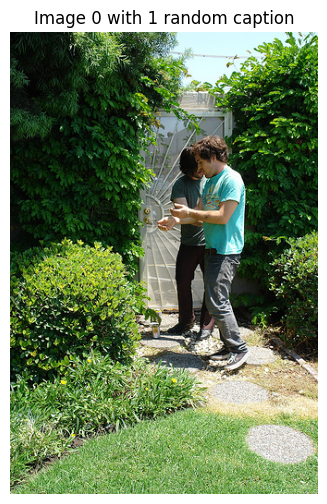

[1] Caption: Several men in hard hats are operating a giant pulley system .


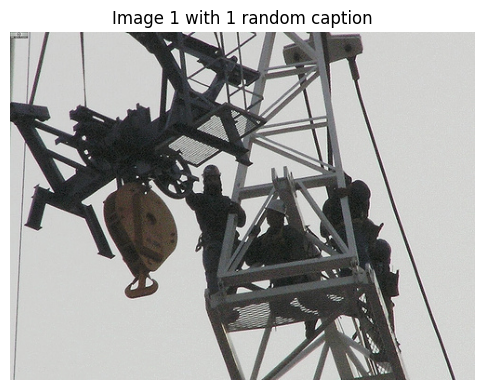

[2] Caption: A little girl climbing the stairs to her playhouse .


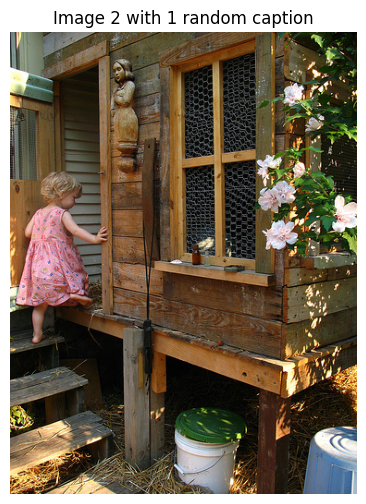

[3] Caption: A man in a blue shirt is standing on a ladder cleaning a window .


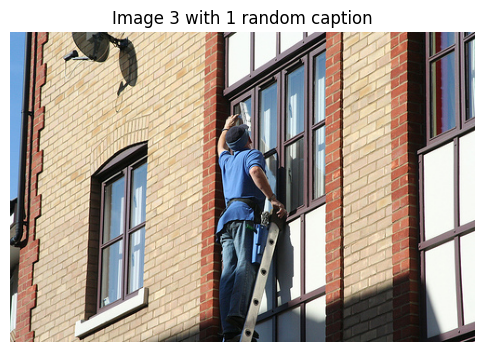

[4] Caption: Two guy cooking and joking around with the camera .


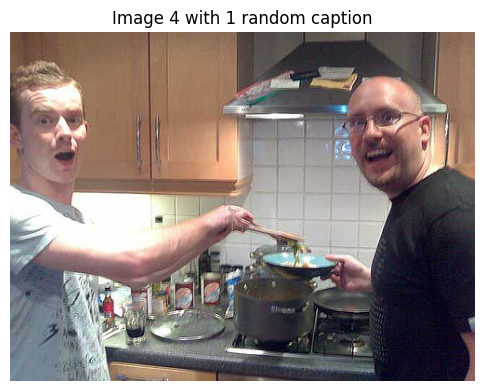

[5] Caption: A man in green holds a guitar while the other man observes his shirt .


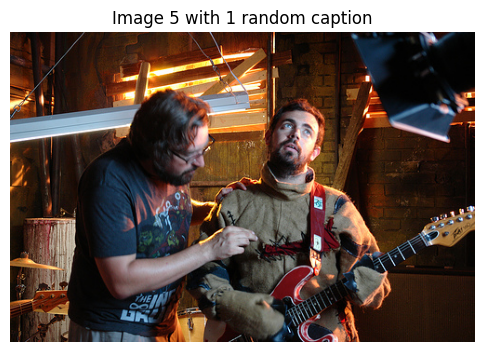

[6] Caption: A man sits in a chair while holding a large stuffed animal of a lion .


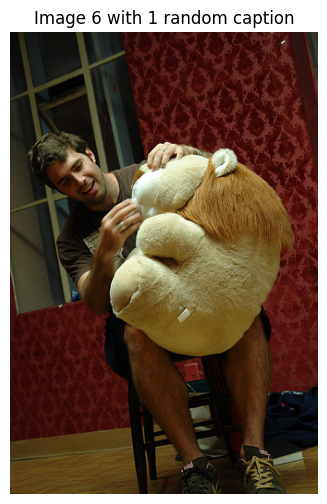

[7] Caption: Woman talking on cellphone and wearing rollerskates .


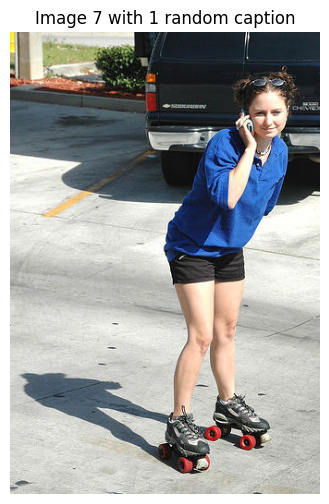

[8] Caption: An asian man wearing a black suit stands near a dark-haired woman and a brown-haired woman .


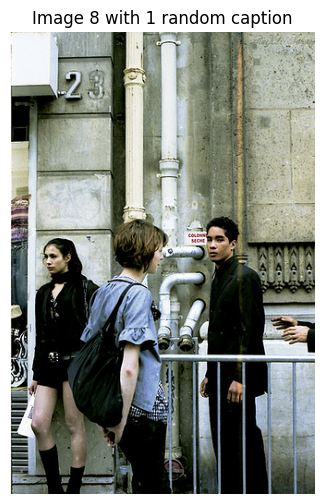

[9] Caption: two guys jumping over a gate together


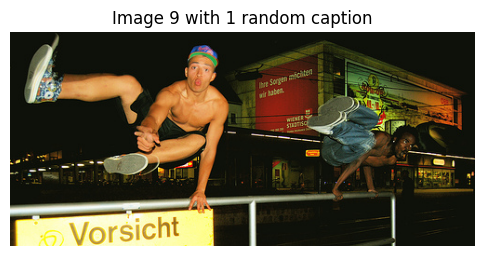

In [5]:
# Set dataset path
image_folder = "/mnt/data1/dina/flickr30k_images"
caption_file = "/mnt/data1/dina/captions.txt"

# Load and transform dataset
dataset = load_flickr30k_dataset(image_folder, caption_file, limit=100)
dataset = dataset.map(transform_images)

# Display the first 10 image-caption pairs
visualize_image_caption_pairs(dataset, num_samples=10)
